In [2]:
import numpy as np
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import time
import imageio
import os
from copy import deepcopy

In [113]:
ndim = len(shape)
ndim

1

In [132]:
def get_nearest_non_diagonal_neighbors(index_flat, shape):
    neighbors = []
    output = []
    ndim = len(shape)

    # Extract indices from the input index
    indices = np.array(np.unravel_index(index_flat, shape))
    if ndim == 1:
        for j in [-1, 1]:
            # Create a copy of the indices
            neighbor_indices = np.array(deepcopy(indices))
            neighbor_indices += j

            if np.any(neighbor_indices < 0):
                neighbor_indices = shape[0]-1
            if np.any(neighbor_indices >= shape[0]):
                neighbor_indices = 0
            # Check if the neighbor indices are within bounds and not diagonal
            if not np.all(neighbor_indices == indices):
                neighbors.append(neighbor_indices)
            return neighbors
                
    else:
        for i in range(ndim):
            for j in [-1, 1]:
                # Create a copy of the indices
                neighbor_indices = np.array(deepcopy(indices))
                neighbor_indices[i] += j

                if np.any(neighbor_indices[i] < 0):
                    neighbor_indices[i] = shape[j]-1
                if np.any(neighbor_indices[i] >= shape[j]):
                    neighbor_indices[i] = 0
                # Check if the neighbor indices are within bounds and not diagonal
                if not np.all(neighbor_indices == indices):
                    neighbors.append(tuple(neighbor_indices))

    for indices in neighbors:
        output.append(np.ravel_multi_index(indices, shape))

    return output

In [133]:
def add_point_ndarray(index, max_height_flat, shape:tuple = None):
    near_neighbors = get_nearest_non_diagonal_neighbors(index, shape)
    height_surrondings = [max_height_flat[neighbor] for neighbor in near_neighbors]

    highest_pos = max([max(height_surrondings), max_height_flat[index]+1])

    max_height_flat[index] = highest_pos
    return max_height_flat

In [134]:
def update_propensities_ndarray(propensities_flat,shape, index, params, dt = 1):
    r = params["r"]
    propensities_flat = np.power(r, dt)*propensities_flat

    propensities_flat[index] = 1

    near_neighbors = get_nearest_non_diagonal_neighbors(index, shape)
    for neighbor in near_neighbors:
        propensities_flat[neighbor] = 1
    return propensities_flat

In [155]:
params = {
    "height":               400,
    "dom":                  400,
    "dim":                    1,
    "t_max":                100,
    "r":                    0.3,
    "dt_snapshot":          100,          
    "n_ptcl_snapshot":      100,
    "gif":                 True,
    "all_resample":       False,
    "foldername":  "SimResults",
    "filename":        "result2",
    }

In [156]:
# def main(params):
height = params["height"]
width = params["dom"]
d = params["dim"]
t = n_ptcls = n_snapshot = 0 
dynamic_cutoff = 0
max_height_time = []

shape = tuple(width for _ in range(d))
max_height_flat = np.zeros((np.power(width, d)), dtype=int) #occupation/height at each site
propensities = np.ones((width**d), dtype = float) #probability of droping at each coordinate
taus = np.random.exponential(1/propensities) #purtiaty times generated from exponential distribution

while(t<params["t_max"]):
    try:
        index_chosen = np.argmin(taus)
        tau_min = taus[index_chosen]
        t += tau_min
        max_height_flat = add_point_ndarray(index_chosen, max_height_flat, shape)
        propensities_new = update_propensities_ndarray(propensities, shape, index_chosen, params, dt = tau_min)
        
        if params["all_resample"]:
            with np.errstate(divide="ignore"):
                taus = np.random.exponential(1/propensities_new)
                taus[np.isnan(taus)] = np.inf
        else:
            with np.errstate(all='ignore'):
                taus = (np.divide(propensities, propensities_new)*(taus - tau_min))
                taus[np.isnan(taus)] = np.inf

            taus[index_chosen
            ] = np.random.exponential(1/propensities_new[index_chosen])

        propensities = propensities_new
        
        if (
            t > n_snapshot*params["dt_snapshot"]
            ) or (
                n_ptcls%params["n_ptcl_snapshot"] == 0
                ):
            max_height_time.append(deepcopy(max_height_flat))
            n_snapshot += 1
        n_ptcls += 1

    except IndexError:
        if (np.max(max_height_flat) == params["height"]-1):
            print(f"Fully Occupied at time: {t}| N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
        else:
            raise IndexError("This IndexError is NOT expected")
        break

    except KeyboardInterrupt:
        print(f"Manually Stopped at time: {t}| N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
        break
else:
    print(f"Stopped at time: {t}| N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
# return max_height_flat

Stopped at time: 100.39499184532228| N_Ptcls: 1568| N_snapshots: 16


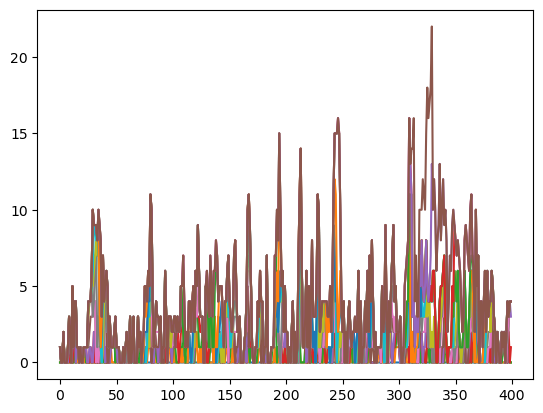

In [160]:
plt.figure()
for i in range(0, len(max_height_time)):
    plt.plot(max_height_time[i])
    
plt.show()
